In [16]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
import os
import mech_io
from pathlib import Path
%matplotlib inline

In [17]:
# variable set up
db = Path(os.path.abspath('')) / "data" / "database" / "2021-05-31_mech_db_clean.db"

# define some colors for later graphing
total_gray = '#B7B9C0'
active_green = '#7AAC91'
hype_purp = '#6C3667'
pct_magen = '#A84D6F'

In [18]:
yearly_query = """
    /* keycap group buy yearly aggregate stats */
    SELECT
        ydata.*,
        num_icodes
    FROM (
        SELECT --this derived table calculates most rows
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(tdata.topic_id) as num_gbs,
            COUNT(DISTINCT creator_id) as num_creators,
            CAST(AVG(views) as INT) as avg_views,
            MAX(views) as max_views,
            CAST(AVG(replies) as INT) as avg_replies,
            MAX(replies) as max_replies,
            COUNT(CASE WHEN num_posts >= 25 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_25_posts,
            COUNT(CASE WHEN num_posts >= 50 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_50_posts,
            AVG(IFNULL(ldata.num_links, 0)) as avg_links
        --average time for gbs reaching 25/50 posts
        FROM topic_data as tdata
        LEFT JOIN (
            SELECT
                topic_id,
                COUNT(id) as num_links
            FROM topic_link
            GROUP BY topic_id
            ) ldata
        ON tdata.topic_id = ldata.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) ydata
    JOIN (
        SELECT --this derived table calculates number of infocodes used
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(DISTINCT icode.info_code) as num_icodes
        FROM topic_data as itdata
        JOIN topic_icode as icode
            ON itdata.topic_id = icode.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) iydata
    ON ydata.gb_year = iydata.gb_year
    ORDER BY gb_year;
    """

post50_query = """
    /* keycap group buy time interval stats (aggregate in python)
        - pulls topic level post_50_delta stats
        - sqlite doesn't support time intervals */
    SELECT
        topic_id,
        STRFTIME('%Y', topic_created) as gb_year,
        post_50_delta
    FROM topic_data
    WHERE product_type = 'keycaps'
            AND board_id = '70'
    ORDER BY gb_year, topic_id
    """

# connect to database and pull data
conn = sqlite3.connect(db)
yearly_df = pd.read_sql_query(yearly_query, conn, index_col="gb_year")
post50_df = pd.read_sql_query(post50_query, conn, index_col="topic_id")
conn.close()

In [19]:
# parse post_50_delta to extract day of 50th post (sqlite doesn't support time intervals)
post50_df['post_50_day'] = post50_df['post_50_delta'].apply(lambda x: mech_io.db_parse_td_str(x)['days'])

# filter topics to find hyped topics reaching 50 posts within 30 days
pop_post_df = post50_df[post50_df['post_50_day'] < 30][['gb_year', 'post_50_day']]

# aggregate across years and calculate percent
hype_df = pop_post_df.groupby(['gb_year']).count()
hype_df.rename(columns={'post_50_day':'count_hyped'}, inplace=True)
hype_df['pct_hyped'] = hype_df['count_hyped'] * 100 / yearly_df['num_gbs']

# join aggregated data with other yearly data
yearly_df = yearly_df.join(hype_df)
yearly_df.reset_index(inplace=True)

In [20]:
yearly_df.head(10)

,gb_year,num_gbs,num_creators,avg_views,max_views,avg_replies,max_replies,percent_25_posts,percent_50_posts,avg_links,num_icodes,count_hyped,pct_hyped
0,2012,6,3,28148,123953,146,687,66.666667,50.000000,0.500000,1,3,50.000000
1,2013,19,10,273925,1600608,795,2537,94.736842,89.473684,1.684211,6,16,84.210526
2,2014,11,6,347062,2001068,833,2305,100.000000,90.909091,1.909091,3,10,90.909091
3,2015,16,12,923409,9396954,1320,5922,100.000000,100.000000,2.812500,6,14,87.500000
4,2016,24,20,133977,767197,319,1076,95.833333,83.333333,2.833333,8,16,66.666667
5,2017,38,31,28367,156940,134,885,78.947368,63.157895,3.394737,5,14,36.842105
6,2018,48,39,45693,139646,211,658,97.916667,81.250000,5.354167,8,26,54.166667
7,2019,90,64,62893,199214,154,841,84.444444,70.000000,5.122222,13,36,40.000000
8,2020,148,107,31307,95061,67,243,82.432432,56.756757,9.432432,13,44,29.729730
9,2021,82,76,10996,32540,33,103,64.634146,24.390244,12.987805,11,8,9.756098


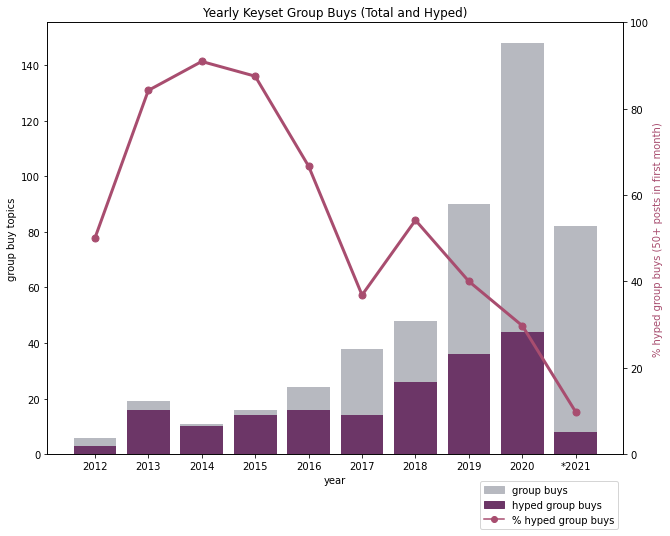

In [21]:
# yearly group buys plot

# create plot and set up twin axis
yearly_plot = plt.figure(figsize=[8,6])
yearly_ax1 = yearly_plot.add_axes([1, 1, 1, 1])
yearly_ax2 = yearly_ax1.twinx()
yearly_ax2.set_ylim(0, 100)

# plot total gbs, hyped gbs, and % popular gbs
yearly_xpos = np.arange(len(yearly_df['gb_year']))
yearly_ax1.bar(yearly_xpos, yearly_df['num_gbs'], color=total_gray)
yearly_ax1.bar(yearly_xpos, yearly_df['count_hyped'], color=hype_purp)

yearly_ax2.plot(yearly_df['gb_year'], yearly_df['pct_hyped'], 
                marker='o', linewidth=3, markersize=7, color=pct_magen)

# TODO: graph a green "active" metric (same as hyped but with 25 posts instead of 50)

# add axis labels/ticks
yearly_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")

yearly_ax1.set_xlabel('year')
yearly_ax1.set_xticks(yearly_xpos)
yearly_xpos_lab = yearly_df['gb_year'].copy()
yearly_xpos_lab.iat[-1] = "*" + yearly_xpos_lab.iat[-1]
yearly_ax1.set_xticklabels(yearly_xpos_lab)

yearly_ax1.set_ylabel('group buy topics')
yearly_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color=pct_magen)

# add legend
gb_patch = mpatches.Patch(color=total_gray, label='group buys')
pop_patch = mpatches.Patch(color=hype_purp, label='hyped group buys')
pct_patch = mlines.Line2D([], [], color=pct_magen, marker='o', label='% hyped group buys')
plt.legend(handles=[gb_patch, pop_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')


## Yearly Group Buy Trends
- since 2014, number of group buys/year has steadily increased (on track to continue in 2021)
    - however, the number of hyped group buys has steadily been decreasing as a % of total group buys
        - increased in absolute terms through 2020, but lagged behind the overall increase in group buys
    - 2021 may be the first year where there is an absolute drop in the number of hyped group buys

- could be an indicator of increasing saturation in the market for keyset group buys
    - production times are increasing and so is the availability of high quality in-stock keycaps
    - if the number of consumers isn't increasing as quickly as the number of group buys, each group buy will receive less attention

- overall lack of engagement in the group buy topics represents a shift in the usage of the topics
    - originally, group buy threads were used for group buy updates and q&a with the creator, discussion of the group buys
        - in early years purchases were even coordinated through the group buy thread itself
    - now, group buy threads are possibly more of an archive or hub for information regarding a group buy 

One possible cause for the lack of responses/engagement with group buy topics is various elements of the group buy moving from the group buy topic to other platforms
- purchasing/signup moving from the topic itself onto one or more vendor sites
- the discussion/q&a etc. moving from the group buy topic itself to other platforms - such as discord



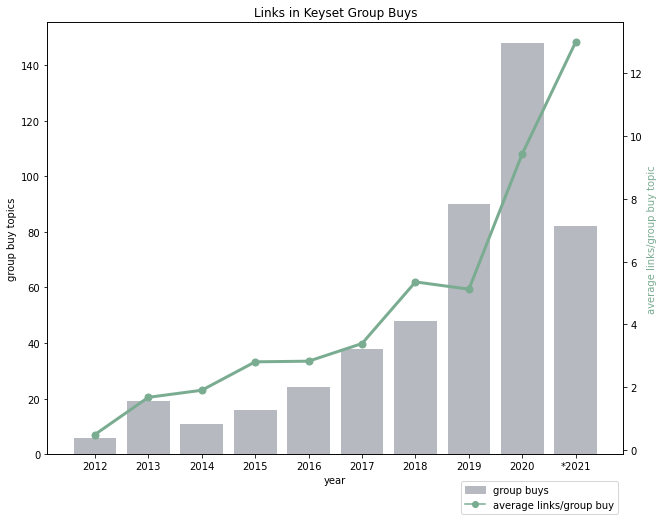

In [22]:
# links group buys plot

# create plot and set up twin axis
links_plot = plt.figure(figsize=[8,6])
links_ax1 = links_plot.add_axes([1, 1, 1, 1])
links_ax2 = links_ax1.twinx()

# plot total gbs, links per gb
links_xpos = np.arange(len(yearly_df['gb_year']))
links_ax1.bar(links_xpos,yearly_df['num_gbs'], color=total_gray)

links_ax2.plot(yearly_df['gb_year'], yearly_df['avg_links'], 
                marker='o', linewidth=3, markersize=7, color=active_green)

# TODO: graph a green "active" metric (same as hyped but with 25 posts instead of 50)

# add axis labels/ticks
links_ax1.set_title("Links in Keyset Group Buys")

links_ax1.set_xlabel('year')
links_ax1.set_xticks(links_xpos)
links_xpos_lab = yearly_df['gb_year'].copy()
links_xpos_lab.iat[-1] = "*" + links_xpos_lab.iat[-1]
links_ax1.set_xticklabels(links_xpos_lab)

links_ax1.set_ylabel('group buy topics')
links_ax2.set_ylabel('average links/group buy topic', color=active_green)

# add legend
gb_patch = mpatches.Patch(color=total_gray, label='group buys')
link_patch = mlines.Line2D([], [], color=active_green, marker='o', label='average links/group buy')
plt.legend(handles=[gb_patch, link_patch], bbox_to_anchor=(1, -0.05), loc='upper right')

In [23]:
discord_query = """
    /* yearly expanded domain/vendor data */
    SELECT
        CASE
            WHEN link LIKE '%discord%' THEN 'discord.gg'
            WHEN LOWER(domain) LIKE ('%' || REPLACE(LOWER(set_name), ' ', '') || '%')
                THEN 'custom domain'
            ELSE LOWER(domain)
        END as domain_type,
        STRFTIME('%Y', tdata.topic_created) as gb_year,
        COUNT(DISTINCT ldata.topic_id) as num_topics,
        COUNT(id) as num_occurances
    FROM topic_link as ldata
    JOIN topic_data as tdata
        ON ldata.topic_id = tdata.topic_id
    WHERE domain_type = 'discord.gg'
    GROUP BY domain_type, gb_year
    ORDER BY gb_year;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
discord_df = pd.read_sql_query(discord_query, conn)
conn.close()

### Links and Vendors for Group Buys
- one possible indication that discussion/purchasing is moving outside of the group buy topics is the steady increase in links/group buy
- some internal links exist (for example, to a related interest check topic)
- most commonly a link in a group buy is a vendor link leading to a page where you can purchase the group buy
    - rise of regional proxies (this likely contributes to the increase in links)
    - also potentially the tie in products (such as deskmats and cables)

In [24]:
# prep discord data for graphing over full set of years

# join with total number of gbs for each year
discord_years = yearly_df.set_index('gb_year')['num_gbs']
discord_df = discord_df.set_index('gb_year').join(discord_years, how='right')
# discord_df.fillna(value=0, inplace=True)
discord_df.reset_index(inplace=True)

# calculate % of gbs mentioning discord
discord_df['pct_discord'] = discord_df['num_topics'] * 100 / discord_df['num_gbs']



In [25]:
discord_df.tail(5)

,gb_year,domain_type,num_topics,num_occurances,num_gbs,pct_discord
5,2017,NaN,NaN,NaN,38,NaN
6,2018,discord.gg,1.0,1.0,48,2.083333
7,2019,discord.gg,20.0,23.0,90,22.222222
8,2020,discord.gg,63.0,68.0,148,42.567568
9,2021,discord.gg,51.0,72.0,82,62.195122


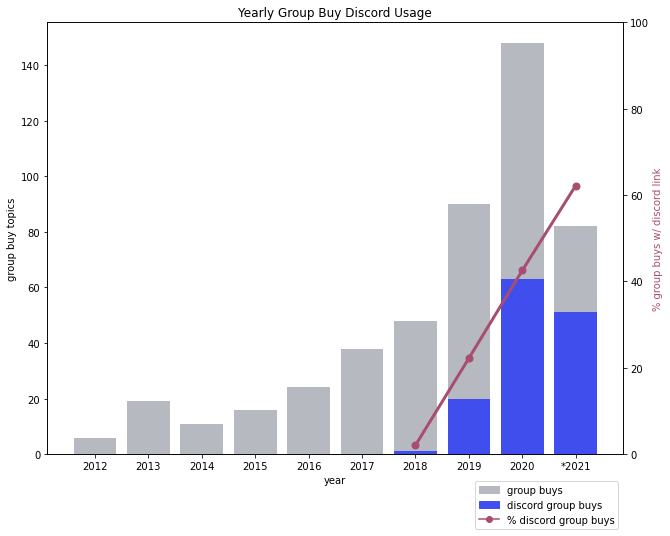

In [26]:
# yearly discord link plot
dcrd_blue = '#404EED'

# create plot and set up twin axis
dcrd_plot = plt.figure(figsize=[8,6])
dcrd_ax1 = dcrd_plot.add_axes([1, 1, 1, 1])
dcrd_ax2 = dcrd_ax1.twinx()

# plot total gbs, discord gbs, and % discord gbs
dcrd_xpos = np.arange(len(discord_df['gb_year']))
dcrd_ax1.bar(dcrd_xpos, discord_df['num_gbs'], color=total_gray)
dcrd_ax1.bar(dcrd_xpos, discord_df['num_topics'], color=dcrd_blue)

dcrd_ax2.plot(discord_df['gb_year'], discord_df['pct_discord'], 
                marker='o', linewidth=3, markersize=7, color=pct_magen)

# add axis labels/ticks
dcrd_ax1.set_title("Yearly Group Buy Discord Usage")

dcrd_ax1.set_xlabel('year')
dcrd_ax1.set_xticks(dcrd_xpos)
dcrd_xpos_lab = discord_df['gb_year'].copy()
dcrd_xpos_lab.iat[-1] = "*" + dcrd_xpos_lab.iat[-1]
dcrd_ax1.set_xticklabels(dcrd_xpos_lab)

dcrd_ax1.set_ylabel('group buy topics')
dcrd_ax2.set_ylabel('% group buys w/ discord link', color=pct_magen)
dcrd_ax2.set_ylim(0, 100)

# create legend
gb_patch = mpatches.Patch(color=total_gray, label='group buys')
dcrd_patch = mpatches.Patch(color=dcrd_blue, label='discord group buys')
pct_patch = mlines.Line2D([], [], color=pct_magen, marker='o', label='% discord group buys')
plt.legend(handles=[gb_patch, dcrd_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')

In [ ]:
### Discord Usage in Group Buys
- first detected instance: 2018
- steady increase until 2021
    - the majority of group buys now contain a discord link
- this trend mirrors the precipitous drop in hyped group buys previously explored
- the popularization of discord is a strong alternative to general discussion within the group buy topic
    - more constant responses, notifications, etc.


In [27]:
icode_query = """
/* yearly icode data */
    SELECT
        info_code,
        STRFTIME('%Y', tdata.topic_created) as gb_year,
        COUNT(info_code) as occurances,
        CAST(AVG(tdata.views) as INT) as average_views,
        MAX(tdata.views) as max_views,
        CAST(AVG(tdata.replies) as INT) as average_replies,
        MAX(tdata.replies) as max_replies
    FROM topic_icode as icode
    JOIN topic_data as tdata
        ON icode.topic_id = tdata.topic_id
    WHERE board_id = '70'
    GROUP BY info_code, gb_year
    ORDER BY gb_year;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
icode_df = pd.read_sql_query(icode_query, conn)
conn.close()

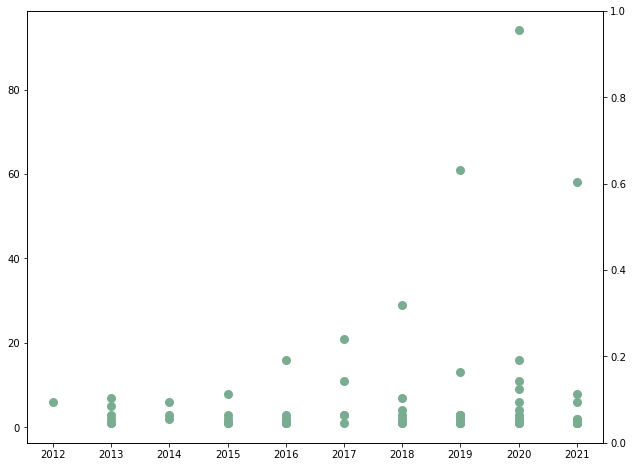

In [28]:
# infocode stats plot

# create plot and set up twin axis
icode_plot = plt.figure(figsize=[8,6])
icode_ax1 = icode_plot.add_axes([1, 1, 1, 1])
icode_ax2 = icode_ax1.twinx()

# plot total gbs, "popular" gbs, and % popular gbs
# sns.barplot(data=yearly_df, x='gb_year', y='num_gbs', palette='crest_r', ax=icode_ax1)
# sns.barplot(data=yearly_df, x='gb_year', y='count_hyped', palette='flare', ax=icode_ax1)
icode_ax1.scatter(icode_df['gb_year'], icode_df['occurances'], 
               marker='o', linewidth=3, color='#7AAC91')
# icode_ax1.scatter(icode_df['occurances'], icode_df['average_views'], 
#                 marker='o', linewidth=3, color='#A84D6F')

# rework this to function on groups of infocodes
# GMK
# Non-GMK ABS
# PBT
# non-standard profiles

# add axis labels/legend
# icode_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")
# icode_ax1.set_xlabel('year')
# icode_ax1.set_ylabel('group buy topics/creators')
# icode_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color='#A84D6F')
# gb_patch = mpatches.Patch(color='#7AAC91', label='group buys')
# pop_patch = mpatches.Patch(color='#6C3667', label='hyped group buys')
# pct_patch = mlines.Line2D([], [], color='#A84D6F', marker='o', label='% hyped group buys')
# plt.legend(handles=[gb_patch, pop_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')

In [30]:
# round 2 timing
# graph time since previous round vs previous round replies? views?
# 